# Labolatorium

### Konfiguracja z inferfejsami

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
from cmath import cos, sin, pi
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from random import uniform, random
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


### Zmienne const potrzebne do wykonania wykresów



In [74]:
A = (-1.0, 0.0)
B = (1.0, 0.1)
NP_DET2X2 = 0
DET2X2 = 1
NP_DET3X3 = 2
DET3X3 = 3
epsilons = [10**(-5), 10**(-8), 10**(-10), 10**(-12), 10**(-18)]
DETS = ["DET2X2", "NP_DET2X2", "DET3X3", "NP_DET3X3"]

#### 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

<IPython.core.display.Javascript object>


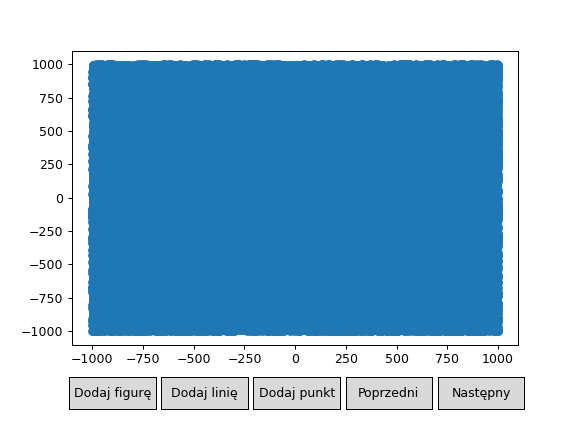

In [75]:
%matplotlib notebook
listOfPoints1 = [(uniform(-1000,1000),uniform(-1000,1000)) for _ in range(10**5)]
points1 = PointsCollection(listOfPoints1)
plot1 = Plot(points = [points1])
plot1.draw()

#### 10^5 losowych punktów o współrzędnych z przedziału [-10^14 , 10^14 ]

<IPython.core.display.Javascript object>


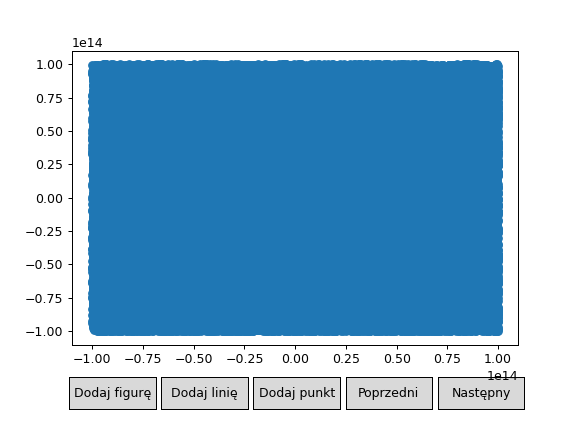

In [97]:
%matplotlib notebook
listOfPoints2 = [(uniform(-10**14, 10**14), uniform(-10**14, 10**14)) for _ in range(10**5)]
points2 = PointsCollection(listOfPoints2)
plot2 = Plot(points = [points2])
plot2.draw()


#### 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

<IPython.core.display.Javascript object>


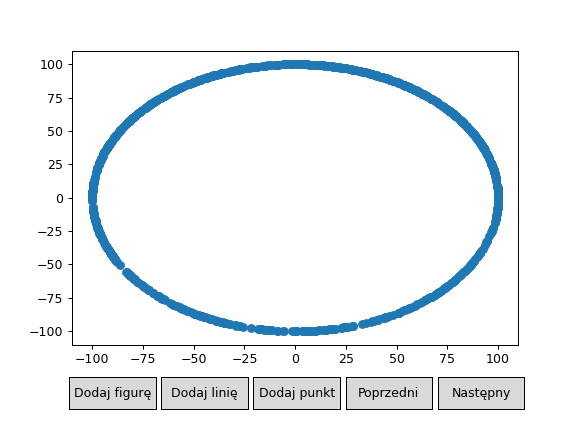

In [77]:
%matplotlib notebook
r = 100
listOfPoints3 = []
for _ in range(1000):
    t = random() * (np.pi*2)
    listOfPoints3.append((r * np.cos(np.pi/2 * t), r * np.sin(np.pi/2 * t)))
points3 = PointsCollection(listOfPoints3)
plot3 = Plot(points= [points3])
plot3.draw()

#### 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b), a = [-1.0, 0.0], b = [1.0, 0.1].

<IPython.core.display.Javascript object>


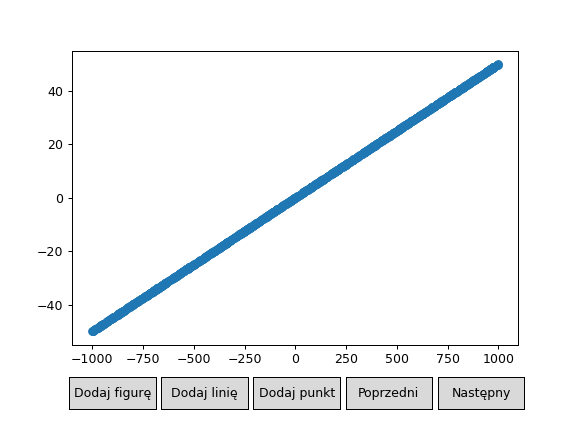

In [78]:
%matplotlib notebook
listOfPoints4 = []
for _ in range(1000):
    x = uniform(-1000,1000)
    y = 0.05 * x + 0.05
    listOfPoints4.append((x, y))
points4 = PointsCollection(listOfPoints4)
plot4 = Plot(points=[points4])
plot4.draw()

### Funkcje do wyznaczników 

In [79]:
def det3x3(c):
    return ((A[0]*B[1]) + (A[1]*c[0]) + (B[0]*c[1]) - (c[0]*B[1]) - (B[0]*A[1]) - (A[0]*c[1]))

def det2x2(c):
    return ((A[0] - c[0])*(B[1] - c[1]) - (A[1] - c[1])*(B[0] - c[0]))

def np_det2x2(c):
    new_array = np.array([[A[0] - c[0], A[1] - c[1]], [B[0] - c[0], B[1] - c[1]]])
    return np.linalg.det(new_array)

def np_det3x3(c):
    new_array = np.array([[A[0], A[1], 1], [B[0], B[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(new_array)

#### Wizualizacja punktów względem prostej

In [80]:
def set_points(points):
    result = [[{'left':[], 'right':[], 'collinear':[]} for epsilon in range(5)] for dets in range(4)]

    for point in points:

        dets = [np_det2x2(point), det2x2(point), np_det3x3(point), det3x3(point)]
        
        for i, det in enumerate(dets):
            for j, epsilon in enumerate(epsilons):
                if abs(det) < epsilon:
                    result[i][j]['collinear'].append(point)
                elif det > 0:
                    result[i][j]['left'].append(point)
                else:
                    result[i][j]['right'].append(point)

    return result

def draw_result(point, det, tolerance):
    plot_of_result = Plot(points = [PointsCollection(point[det][tolerance]['left'], color = 'red'),
                                    PointsCollection(point[det][tolerance]['right'], color = 'green'),
                                    PointsCollection(point[det][tolerance]['collinear'], color = 'blue')])
    plot_of_result.draw()
    print("Counter of points:")
    print("Left: " + str(len(point[det][4]['left'])) + " Right: " + str(len(point[det][4]['right']))
            + " Collinear: " + str(len(point[det][4]['collinear'])))

### Posegregoanie punktów względem prostej i tolerancji epsilon

In [81]:
points1plot = set_points(listOfPoints1)
points2plot = set_points(listOfPoints2)
points3plot = set_points(listOfPoints3)
points4plot = set_points(listOfPoints4)

## Wizualizacja punktów dla tolerancji = 1e-18 i różnych wyznaczników

### Zestw I punktów

<IPython.core.display.Javascript object>


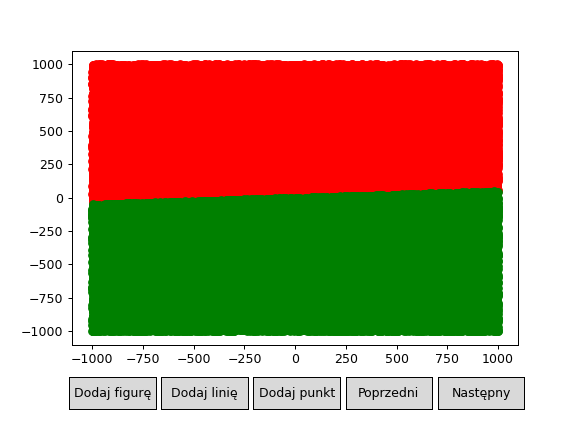

Counter of points:
Left: 50098 Right: 49902 Collinear: 0


In [98]:
%matplotlib notebook
draw_result(points1plot, NP_DET2X2, 4)

<IPython.core.display.Javascript object>


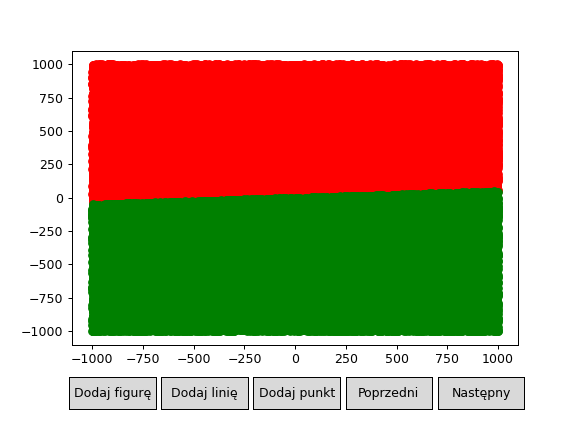

Counter of points:
Left: 50098 Right: 49902 Collinear: 0


In [99]:
%matplotlib notebook
draw_result(points1plot, DET2X2, 4)

<IPython.core.display.Javascript object>


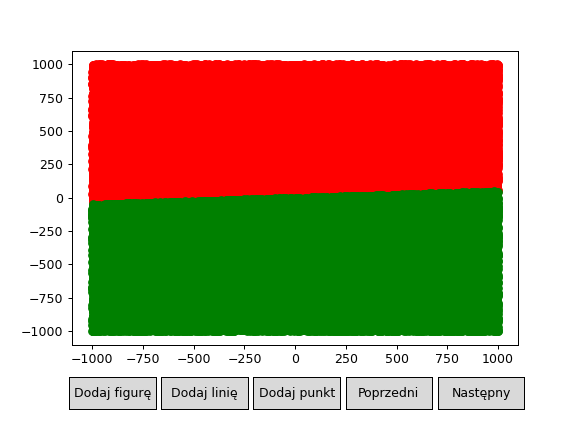

Counter of points:
Left: 50098 Right: 49902 Collinear: 0


In [84]:
%matplotlib notebook
draw_result(points1plot, NP_DET3X3, 4)

<IPython.core.display.Javascript object>


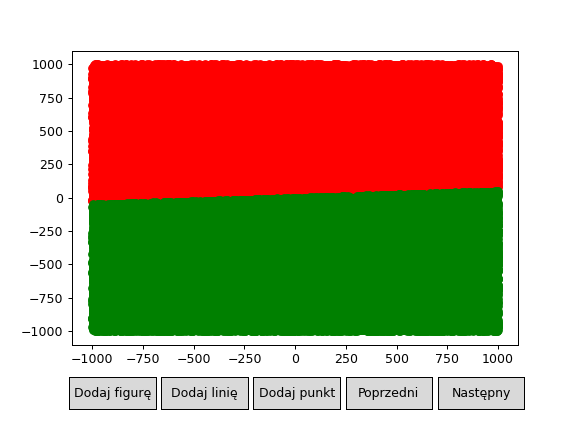

Counter of points:
Left: 49783 Right: 50217 Collinear: 0


In [53]:
%matplotlib notebook
draw_result(points1plot, DET3X3, 4)

### Zestaw II punktów

<IPython.core.display.Javascript object>


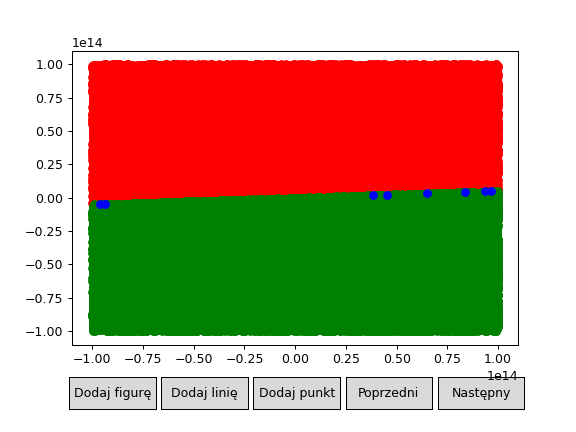

Counter of points:
Left: 49782 Right: 50210 Collinear: 8


In [85]:
%matplotlib notebook
draw_result(points2plot, NP_DET2X2, 4)
# print(points2plot[NP_DET2X2][4]['collinear'])

<IPython.core.display.Javascript object>


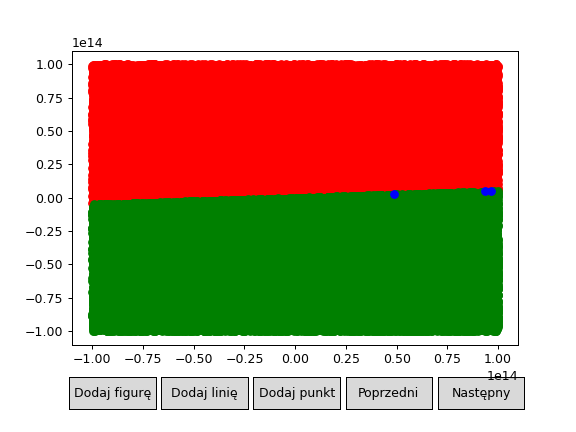

Counter of points:
Left: 49784 Right: 50213 Collinear: 3


In [86]:
%matplotlib notebook
draw_result(points2plot, DET2X2, 4)

<IPython.core.display.Javascript object>


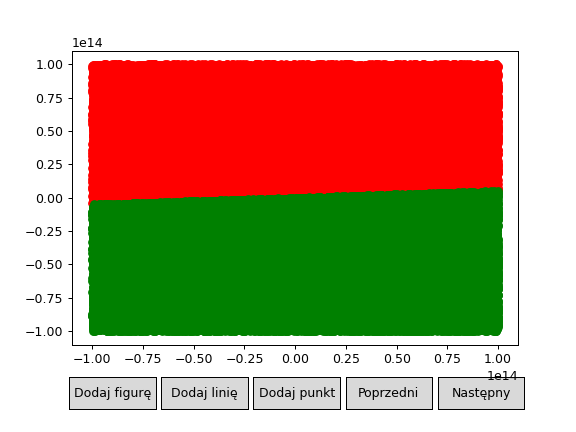

Counter of points:
Left: 49786 Right: 50214 Collinear: 0


In [87]:
%matplotlib notebook
draw_result(points2plot, NP_DET3X3, 4)

<IPython.core.display.Javascript object>


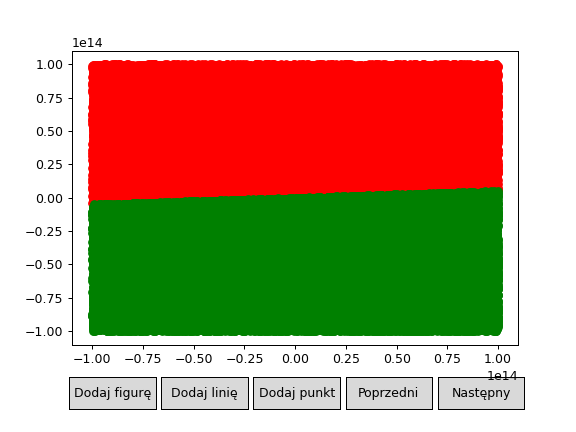

Counter of points:
Left: 49786 Right: 50214 Collinear: 0


In [88]:
%matplotlib notebook
draw_result(points2plot, DET3X3, 4)

### Zestaaw III punktów

<IPython.core.display.Javascript object>


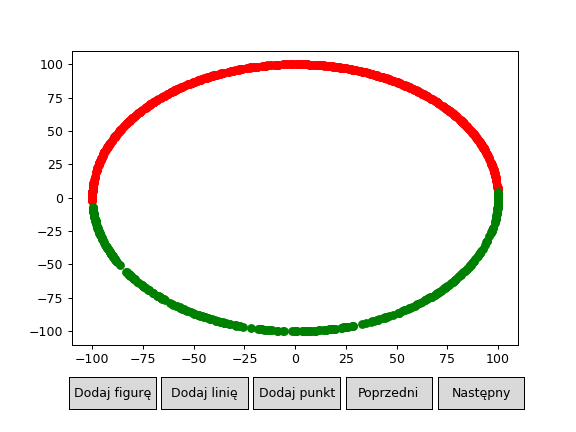

Counter of points:
Left: 623 Right: 377 Collinear: 0


In [89]:
%matplotlib notebook
draw_result(points3plot, NP_DET2X2, 4)

<IPython.core.display.Javascript object>


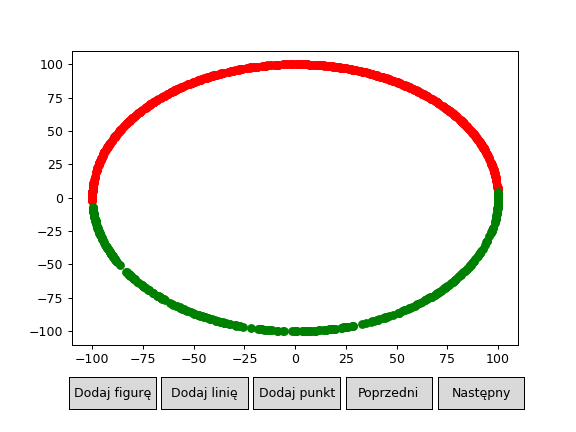

Counter of points:
Left: 623 Right: 377 Collinear: 0


In [90]:
%matplotlib notebook
draw_result(points3plot, DET2X2, 4)

<IPython.core.display.Javascript object>


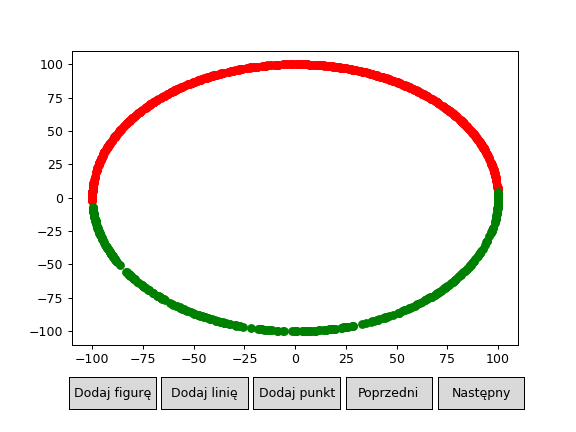

Counter of points:
Left: 623 Right: 377 Collinear: 0


In [91]:
%matplotlib notebook
draw_result(points3plot, NP_DET3X3, 4)

<IPython.core.display.Javascript object>


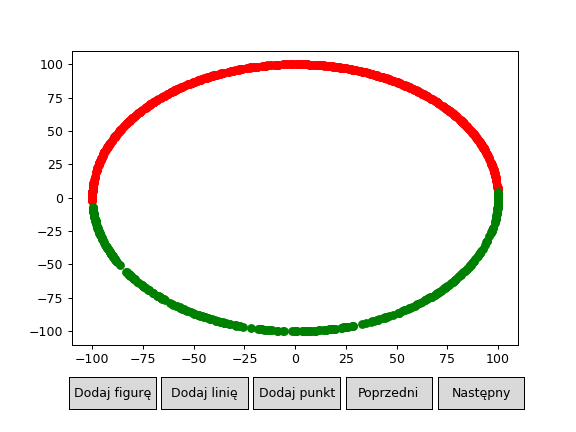

Counter of points:
Left: 623 Right: 377 Collinear: 0


In [92]:
%matplotlib notebook
draw_result(points3plot, DET3X3, 4)

### Zestaw IV punktów

<IPython.core.display.Javascript object>


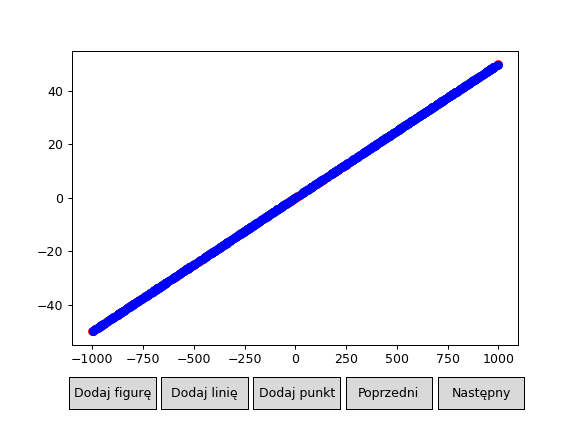

Counter of points:
Left: 144 Right: 157 Collinear: 699


In [93]:
%matplotlib notebook
draw_result(points4plot, NP_DET2X2, 4)

<IPython.core.display.Javascript object>


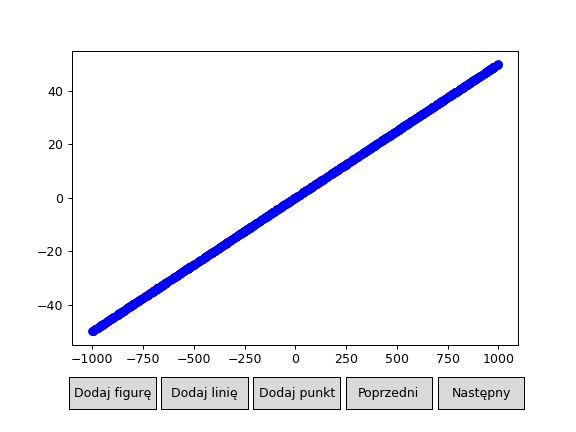

Counter of points:
Left: 158 Right: 159 Collinear: 683


In [94]:
%matplotlib notebook
draw_result(points4plot, DET2X2, 4)

<IPython.core.display.Javascript object>


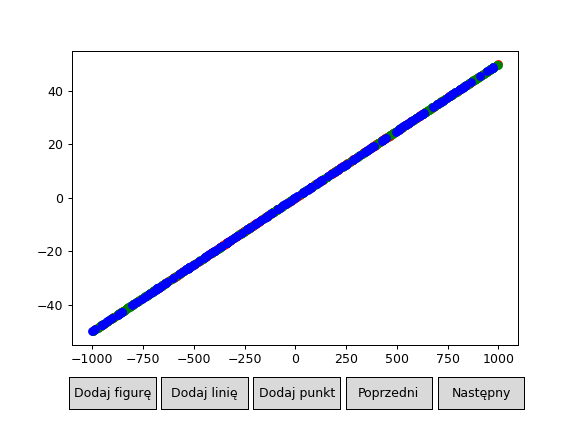

Counter of points:
Left: 356 Right: 457 Collinear: 187


In [95]:
%matplotlib notebook
draw_result(points4plot, NP_DET3X3, 4)

<IPython.core.display.Javascript object>


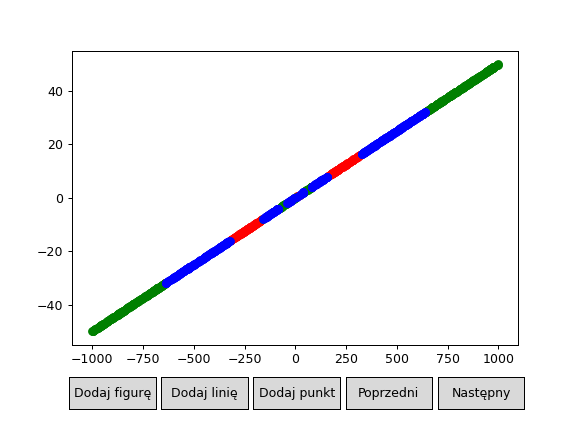

Counter of points:
Left: 165 Right: 411 Collinear: 424


In [96]:
%matplotlib notebook
draw_result(points4plot, DET3X3, 4)

## Wizualizacja i obliczenie punktów uzyskanych przy pomocy różnych wyznaczników

In [26]:
def different_points(points, det1, det2, tolerance1):
    
    listOfAssignment1 = []
    listOfAssignment2 = []

    for point in points[det1][tolerance1]['left']:
        listOfAssignment1.append((point, 'left'))
    for point in points[det1][tolerance1]['right']:
        listOfAssignment1.append((point, 'right'))
    for point in points[det1][tolerance1]['collinear']:
        listOfAssignment1.append((point, 'collinear'))
    
    for point in points[det2][tolerance1]['left']:
        listOfAssignment2.append((point, 'left'))
    for point in points[det2][tolerance1]['right']:
        listOfAssignment2.append((point, 'right'))
    for point in points[det2][tolerance1]['collinear']:
        listOfAssignment2.append((point, 'collinear'))
    
    listOfAssignment1.sort()
    listOfAssignment2.sort()

    pointsToDraw = []

    for i in range(len(listOfAssignment1)):
        if listOfAssignment1[i][1] != listOfAssignment2[i][1]:
            pointsToDraw.append(listOfAssignment1[i][0])
    return pointsToDraw

def draw_different_points(points):
    plot = Plot(points = [PointsCollection(points, color = 'red')])
    plot.draw()
    
    print("Amount of different points: " + str(len(points)))

### Zestaw I

<IPython.core.display.Javascript object>


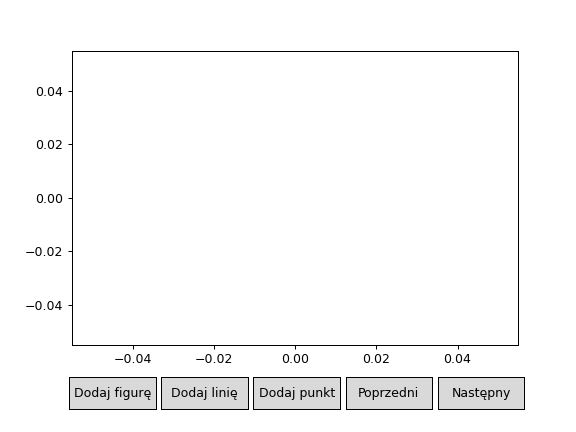

Amount of different points: 0


In [54]:
%matplotlib notebook
draw_different_points(different_points(points1plot, NP_DET2X2, DET2X2, 4))

<IPython.core.display.Javascript object>


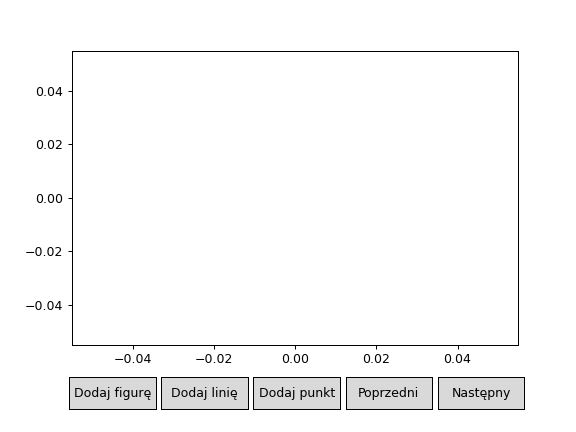

Amount of different points: 0


In [55]:
%matplotlib notebook
draw_different_points(different_points(points1plot, NP_DET2X2, DET3X3, 4))

<IPython.core.display.Javascript object>


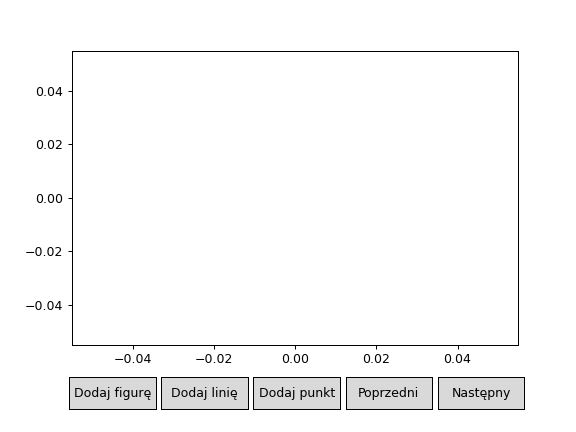

Amount of different points: 0


In [56]:
%matplotlib notebook
draw_different_points(different_points(points1plot, NP_DET3X3, DET2X2, 4))

<IPython.core.display.Javascript object>


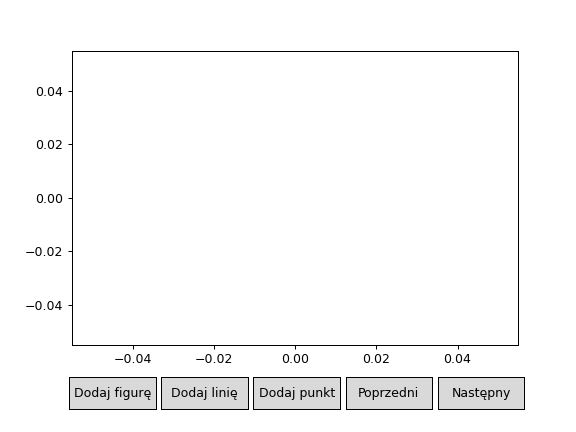

Amount of different points: 0


In [67]:
%matplotlib notebook
draw_different_points(different_points(points1plot, NP_DET3X3, DET3X3, 4))

### Zestaw II

<IPython.core.display.Javascript object>


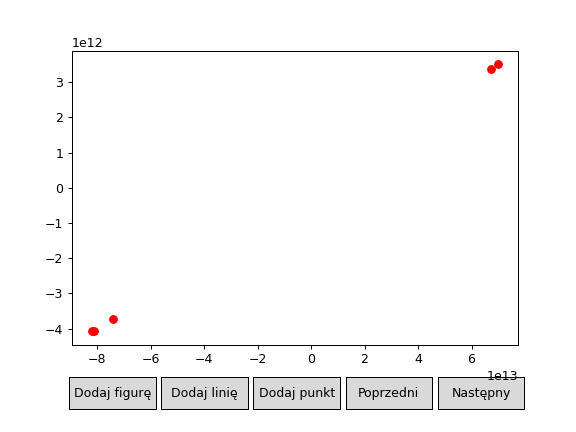

Amount of different points: 5


In [73]:
%matplotlib notebook
draw_different_points(different_points(points2plot, NP_DET2X2, DET2X2, 4))

<IPython.core.display.Javascript object>


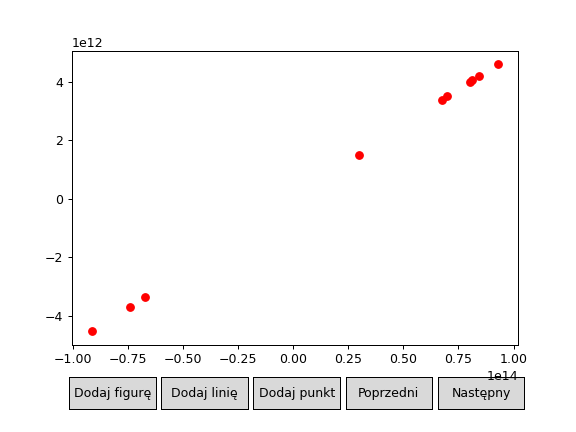

Amount of different points: 10


In [57]:
%matplotlib notebook
draw_different_points(different_points(points2plot, NP_DET2X2, DET3X3, 4))

<IPython.core.display.Javascript object>


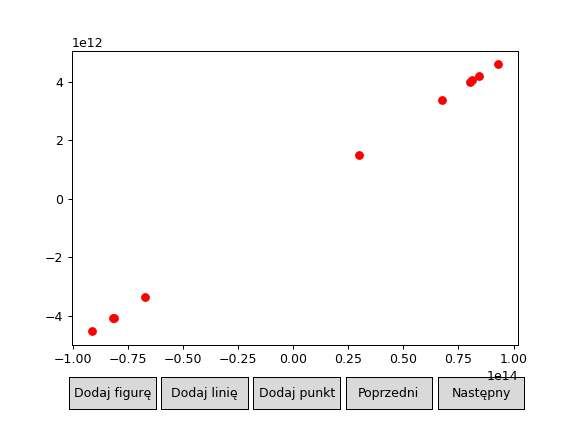

Amount of different points: 10


In [58]:
%matplotlib notebook
draw_different_points(different_points(points2plot, NP_DET3X3, DET2X2, 4))

<IPython.core.display.Javascript object>


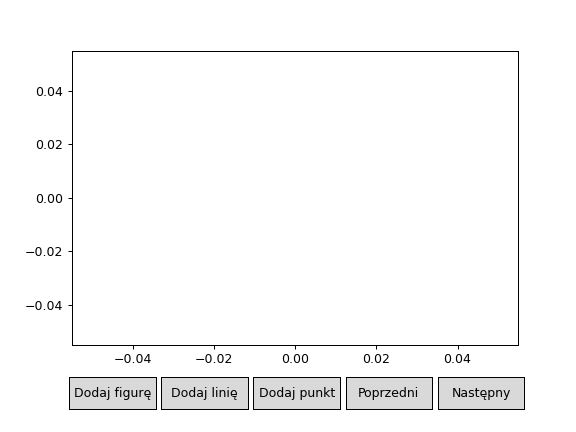

Amount of different points: 0


In [69]:
%matplotlib notebook
draw_different_points(different_points(points2plot, NP_DET3X3, DET3X3, 4))


### Zestaw III

<IPython.core.display.Javascript object>


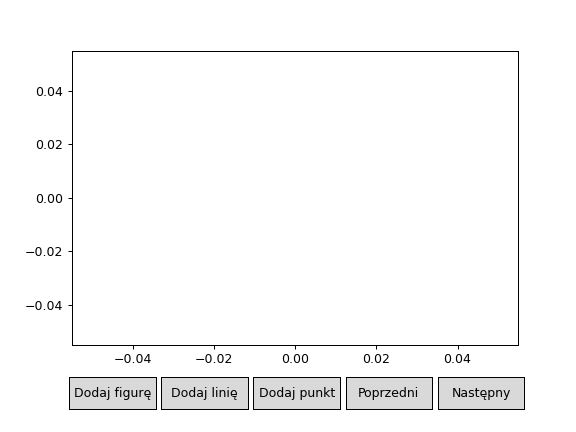

Amount of different points: 0


In [70]:
%matplotlib notebook
draw_different_points(different_points(points3plot, NP_DET2X2, DET2X2, 4))

<IPython.core.display.Javascript object>


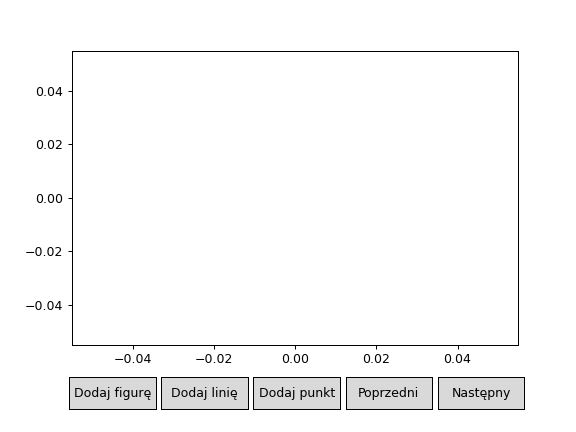

Amount of different points: 0


In [61]:
%matplotlib notebook
draw_different_points(different_points(points3plot, NP_DET2X2, DET3X3, 4))

<IPython.core.display.Javascript object>


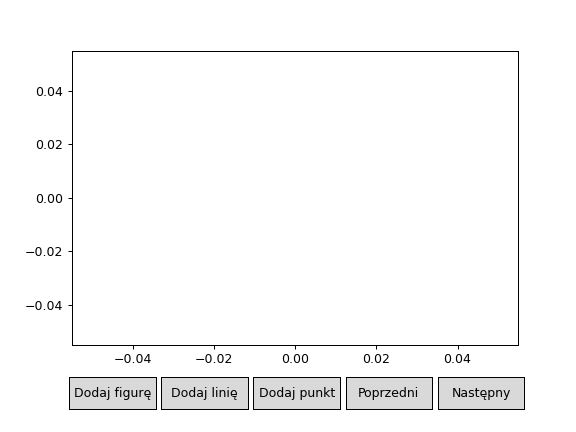

Amount of different points: 0


In [62]:
%matplotlib notebook
draw_different_points(different_points(points3plot, NP_DET3X3, DET2X2, 4))

<IPython.core.display.Javascript object>


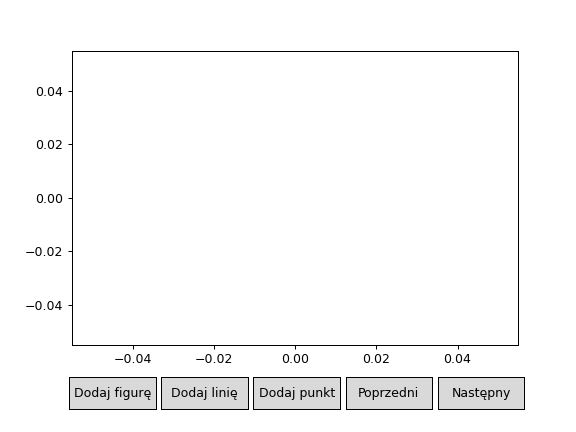

Amount of different points: 0


In [71]:
%matplotlib notebook
draw_different_points(different_points(points3plot, NP_DET3X3, DET3X3, 4))

### Zestaw IV

<IPython.core.display.Javascript object>


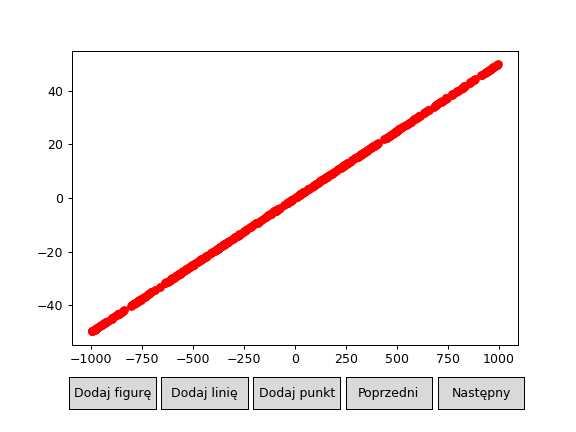

Amount of different points: 402


In [72]:
%matplotlib notebook
draw_different_points(different_points(points4plot, NP_DET2X2, DET2X2, 4))

<IPython.core.display.Javascript object>


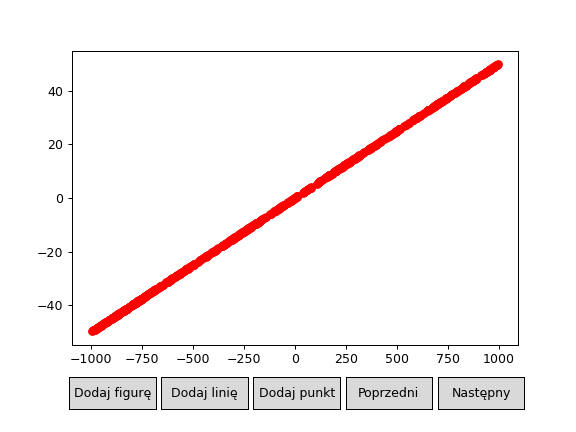

Amount of different points: 652


In [63]:
%matplotlib notebook
draw_different_points(different_points(points4plot, NP_DET2X2, DET3X3, 4))

<IPython.core.display.Javascript object>


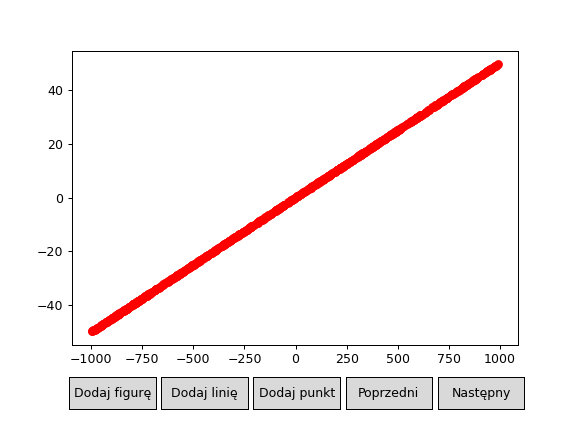

Amount of different points: 715


In [65]:
%matplotlib notebook
draw_different_points(different_points(points4plot, NP_DET3X3, DET2X2, 4))

<IPython.core.display.Javascript object>


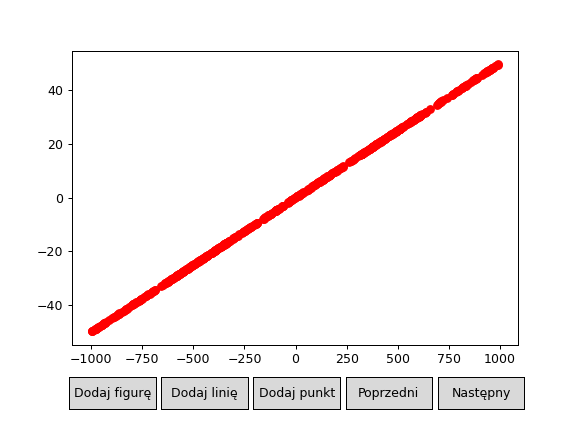

Amount of different points: 567


In [66]:
%matplotlib notebook
draw_different_points(different_points(points4plot, NP_DET3X3, DET3X3, 4))

## Zbadanie wyników dla różnej tolerancji dla zera i różnych precyzji obliczeń

In [36]:
columns = ('Left', 'Right', 'Collinear')
rows = [str(x) for x in epsilons]
n_rows = len(rows)
n_col = len(columns)

def show_diff(det, plot):

    cell_text = [[0 for _ in range(n_col)] for _ in range(n_rows)]

    for i in range(n_rows):
        cell_text[i][0] = len(plot[det][i]['left'])
        cell_text[i][1] = len(plot[det][i]['right'])
        cell_text[i][2] = len(plot[det][i]['collinear'])

    print("------------------------------"+ DETS[det] + "-----------------------------")
    print("|---------------------------------------------------------------|")
    print("|               |               |               |               |")
    print("|     Epsilon   |       Left    |     Right     |    Collinear  |")
    print("|               |               |               |               |")
    print("|---------------------------------------------------------------|")
    print("|                                                               |")
    print("|\t" + str(rows[0]) + "\t|\t" + str(cell_text[0][0]) + "\t|\t" + str(cell_text[0][1]) + "\t|\t" + str(cell_text[0][2]) + "\t|")
    print("|                                                               |")
    print("|---------------------------------------------------------------|")
    print("|                                                               |")
    print("|\t" + str(rows[1]) + "\t|\t" + str(cell_text[1][0]) + "\t|\t" + str(cell_text[1][1]) + "\t|\t" + str(cell_text[1][2]) + "\t|")
    print("|                                                               |")
    print("|---------------------------------------------------------------|")
    print("|                                                               |")
    print("|\t" + str(rows[2]) + "\t|\t" + str(cell_text[2][0]) + "\t|\t" + str(cell_text[2][1]) + "\t|\t" + str(cell_text[2][2]) + "\t|")
    print("|                                                               |")
    print("|---------------------------------------------------------------|")
    print("|                                                               |")
    print("|\t" + str(rows[3]) + "\t|\t" + str(cell_text[3][0]) + "\t|\t" + str(cell_text[3][1]) + "\t|\t" + str(cell_text[3][2]) + "\t|")
    print("|                                                               |")
    print("|---------------------------------------------------------------|")
    print("|                                                               |")
    print("|\t" + str(rows[4]) + "\t|\t" + str(cell_text[4][0]) + "\t|\t" + str(cell_text[4][1]) + "\t|\t" + str(cell_text[4][2]) + "\t|")
    print("|                                                               |")
    print("|---------------------------------------------------------------|")
  

### Zestaw I

In [37]:
%matplotlib notebook
show_diff(0, points1plot)

------------------------------DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	49783	|	50217	|	0	|
|                                                   

In [38]:
%matplotlib notebook
show_diff(1, points1plot)

------------------------------NP_DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	49783	|	50217	|	0	|
|                                                

In [39]:
%matplotlib notebook
show_diff(2, points1plot)

------------------------------DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	49783	|	50217	|	0	|
|                                                   

In [40]:
%matplotlib notebook
show_diff(3, points1plot)

------------------------------NP_DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	49783	|	50217	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	49783	|	50217	|	0	|
|                                                

### Zestaw II

In [41]:
%matplotlib notebook
show_diff(0, points2plot)

------------------------------DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	50070	|	49921	|	9	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	50070	|	49921	|	9	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	50070	|	49921	|	9	|
|                                                   

In [42]:
%matplotlib notebook
show_diff(1, points2plot)

------------------------------NP_DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	50070	|	49920	|	10	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	50070	|	49920	|	10	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	50070	|	49920	|	10	|
|                                             

In [43]:
%matplotlib notebook
show_diff(2, points2plot)

------------------------------DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	50076	|	49924	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	50076	|	49924	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	50076	|	49924	|	0	|
|                                                   

In [44]:
%matplotlib notebook
show_diff(3, points2plot)


------------------------------NP_DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	50076	|	49924	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	50076	|	49924	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	50076	|	49924	|	0	|
|                                                

### Zestaw III

In [45]:
%matplotlib notebook
show_diff(0, points3plot)

------------------------------DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	642	|	358	|	0	|
|                                                               

In [46]:
%matplotlib notebook
show_diff(1, points3plot)

------------------------------NP_DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	642	|	358	|	0	|
|                                                            

In [47]:
%matplotlib notebook
show_diff(2, points3plot)

------------------------------DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	642	|	358	|	0	|
|                                                               

In [48]:
%matplotlib notebook
show_diff(3, points3plot)

------------------------------NP_DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	642	|	358	|	0	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	642	|	358	|	0	|
|                                                            

### Zestaw IV

In [49]:
%matplotlib notebook
show_diff(0, points4plot)

------------------------------DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	0	|	0	|	1000	|
|                                                               |
|

In [50]:
%matplotlib notebook
show_diff(1, points4plot)

------------------------------NP_DET2X2-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	0	|	0	|	1000	|
|                                                               

In [51]:
%matplotlib notebook
show_diff(2, points4plot)

------------------------------DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	0	|	0	|	1000	|
|                                                               |
|

In [52]:
%matplotlib notebook
show_diff(3, points4plot)

------------------------------NP_DET3X3-----------------------------
|---------------------------------------------------------------|
|               |               |               |               |
|     Epsilon   |       Left    |     Right     |    Collinear  |
|               |               |               |               |
|---------------------------------------------------------------|
|                                                               |
|	1e-05	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-08	|	0	|	0	|	1000	|
|                                                               |
|---------------------------------------------------------------|
|                                                               |
|	1e-10	|	0	|	0	|	1000	|
|                                                               